<a href="https://colab.research.google.com/github/varunonthisside/MachineLearning/blob/main/Gold_Prediction_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data
df = pd.read_csv('/content/gold_monthly_csv.csv')
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [5]:
# Shape
df.shape

(847, 2)

In [6]:
# EDA
print(f"Date range of gold prices available from  {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of gold prices available from  1950-01 to 2020-07


In [7]:
date = pd.date_range(start='1/1/1950', end = '8/1/2020', freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [8]:
df['Month'] = date
df.drop('Date',axis =1, inplace = True)
df = df.set_index('Month')
df.head()

,Price
Month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


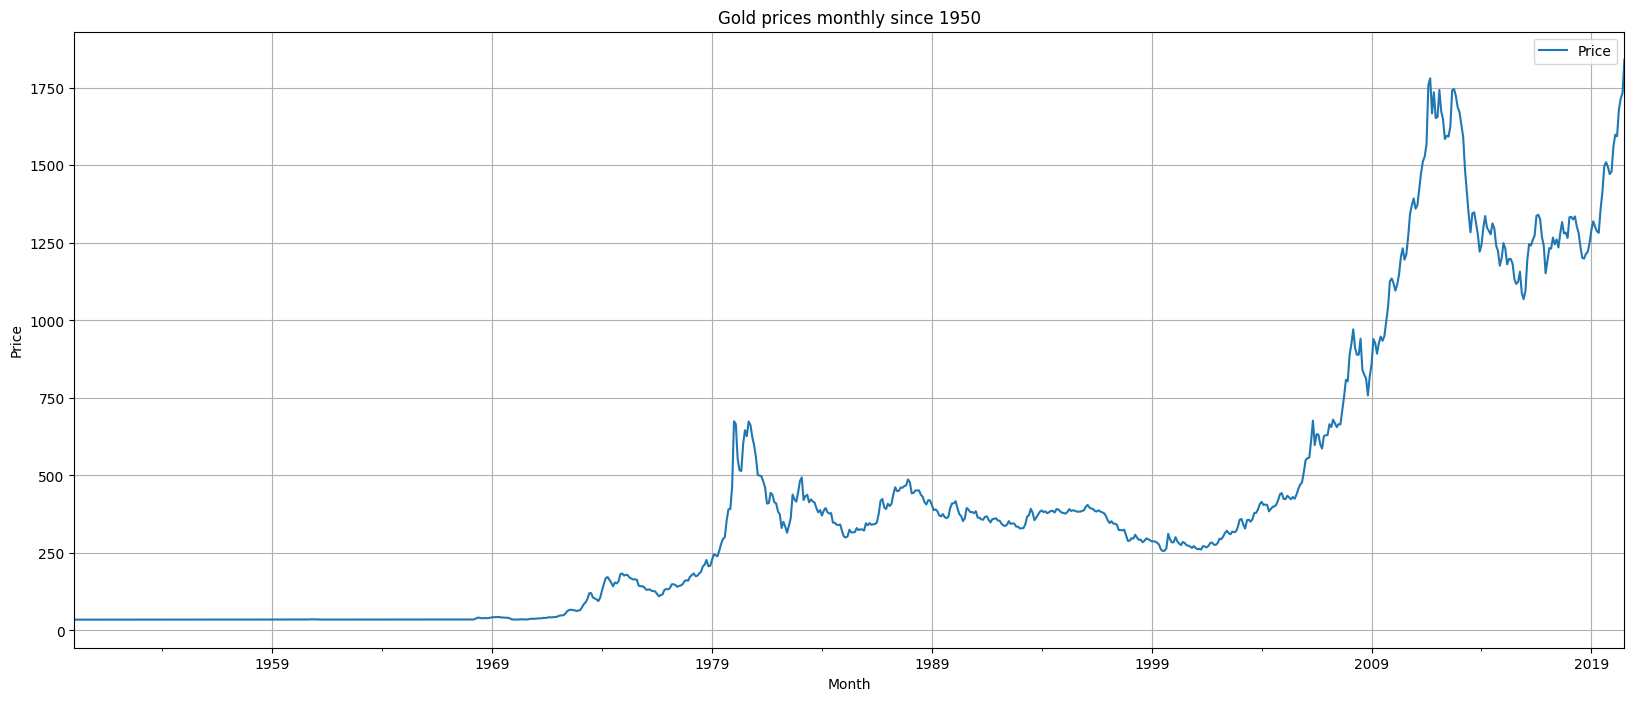

In [9]:
df.plot(figsize=(20,8))
plt.title('Gold prices monthly since 1950')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid()

In [10]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


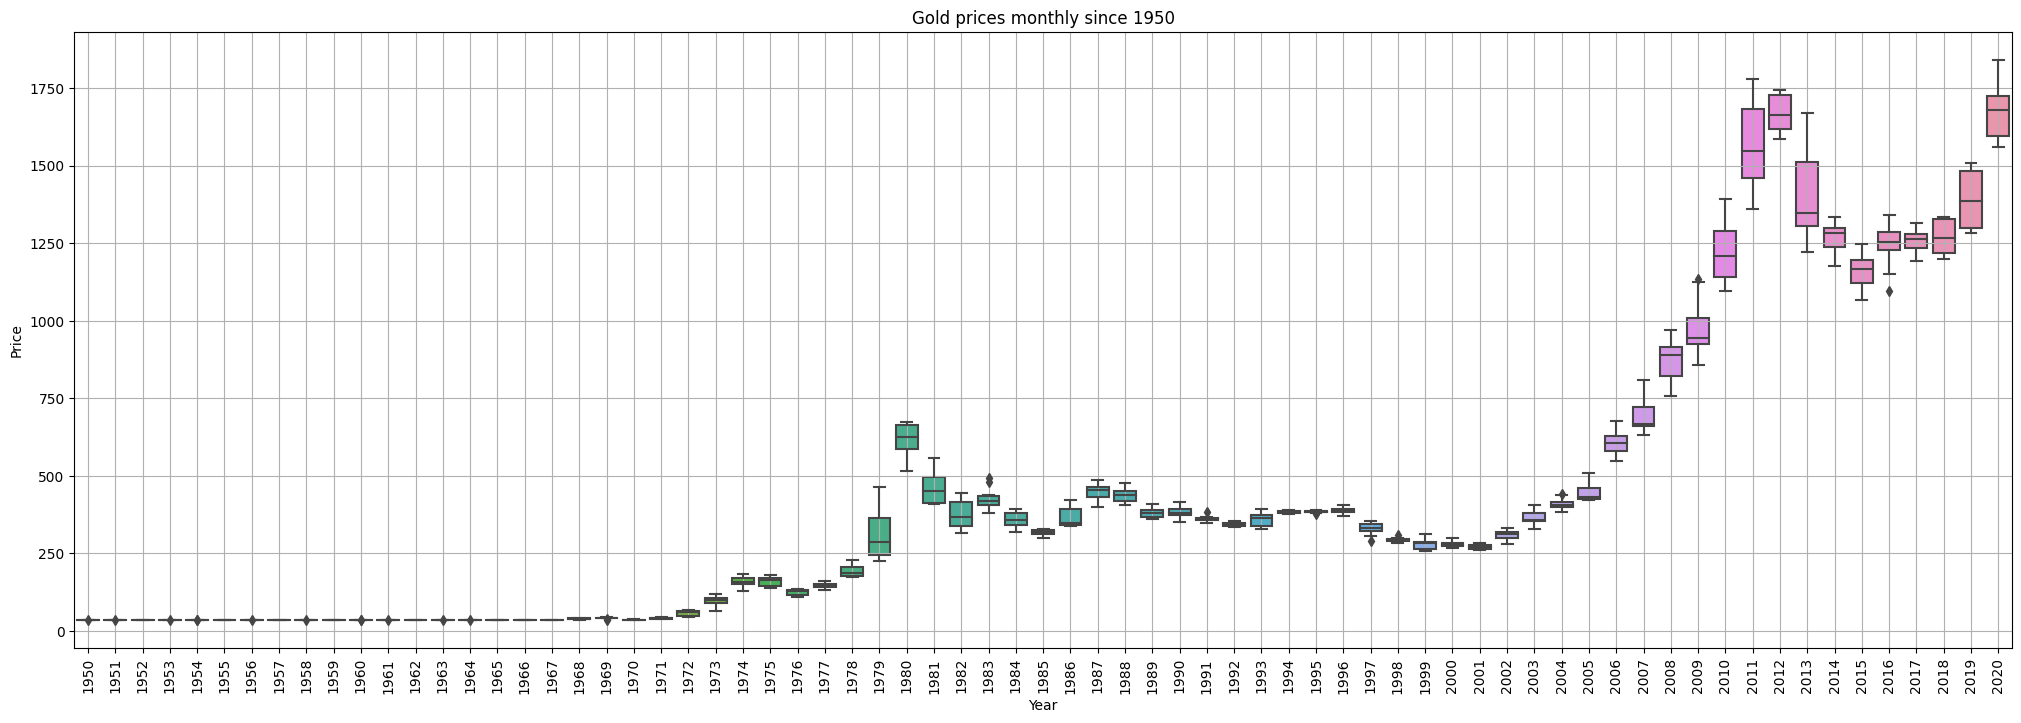

In [11]:
_, ax = plt.subplots(figsize = (25,8))
sns.boxplot(x = df.index.year, y = df.values[:,0], ax=ax)
plt.title('Gold prices monthly since 1950')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation = 90)
plt.grid()

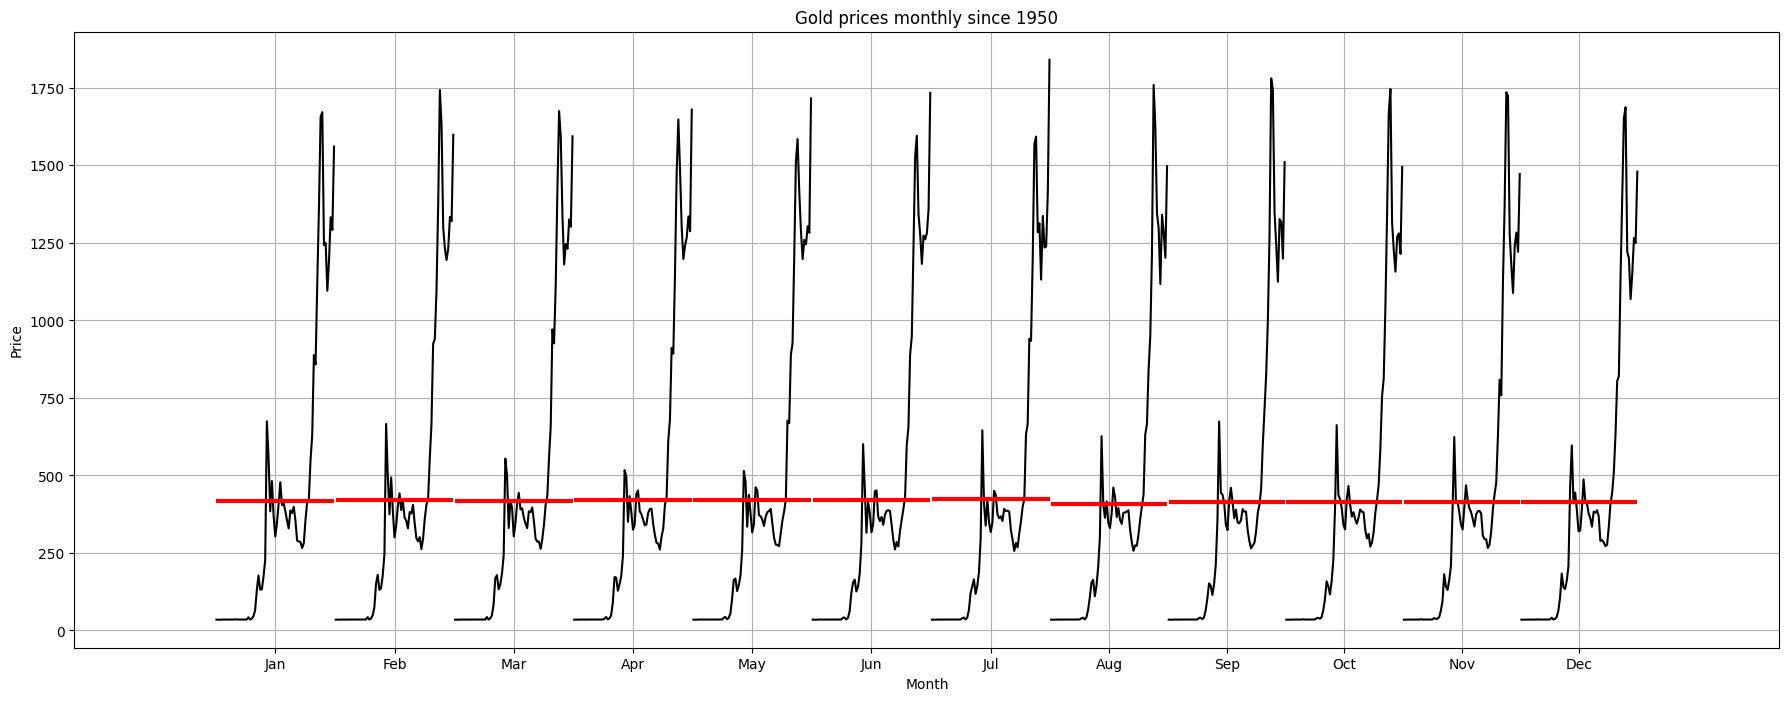

In [12]:
from statsmodels.graphics.tsaplots import month_plot
fig, ax = plt.subplots(figsize = (22,8))
month_plot(df, ylabel = 'Gold Price', ax = ax)
plt.title('Gold prices monthly since 1950')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid()

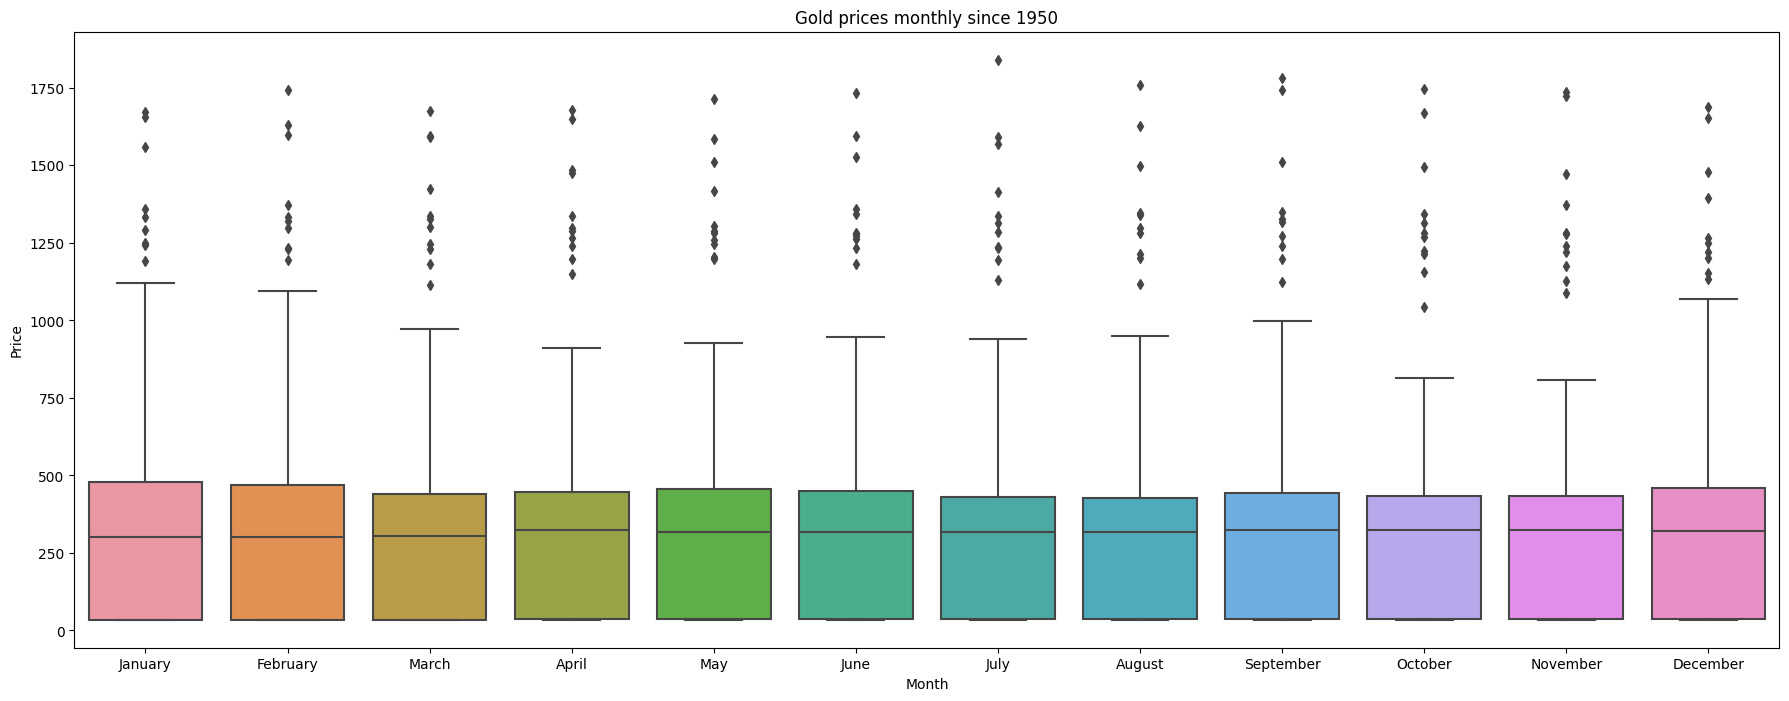

In [13]:
_, ax = plt.subplots(figsize = (22,8))
sns.boxplot(x = df.index.month_name(), y = df.values[:,0], ax = ax)
plt.title('Gold prices monthly since 1950')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

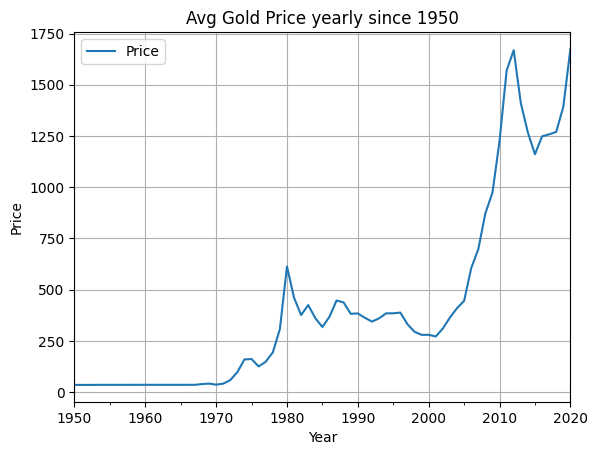

In [14]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot()
plt.title('Avg Gold Price yearly since 1950')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid()

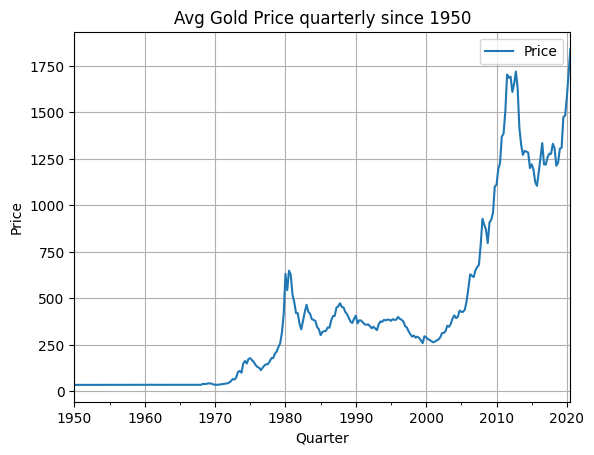

In [15]:
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot()
plt.title('Avg Gold Price quarterly since 1950')
plt.xlabel('Quarter')
plt.ylabel('Price')
plt.grid()

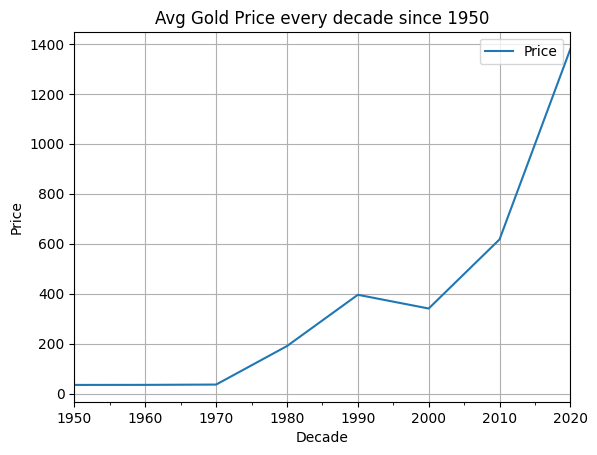

In [16]:
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot()
plt.title('Avg Gold Price every decade since 1950')
plt.xlabel('Decade')
plt.ylabel('Price')
plt.grid()

In [17]:
df_1 = df.groupby(df.index.year).mean().rename(columns = {'Price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns = {'Price':'Std'}), left_index = True, right_index = True)
df_1['Cov_pct'] = ((df_1['Std']/df_1["Mean"])*100).round(2)
df_1.head()

,Mean,Std,Cov_pct
Month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


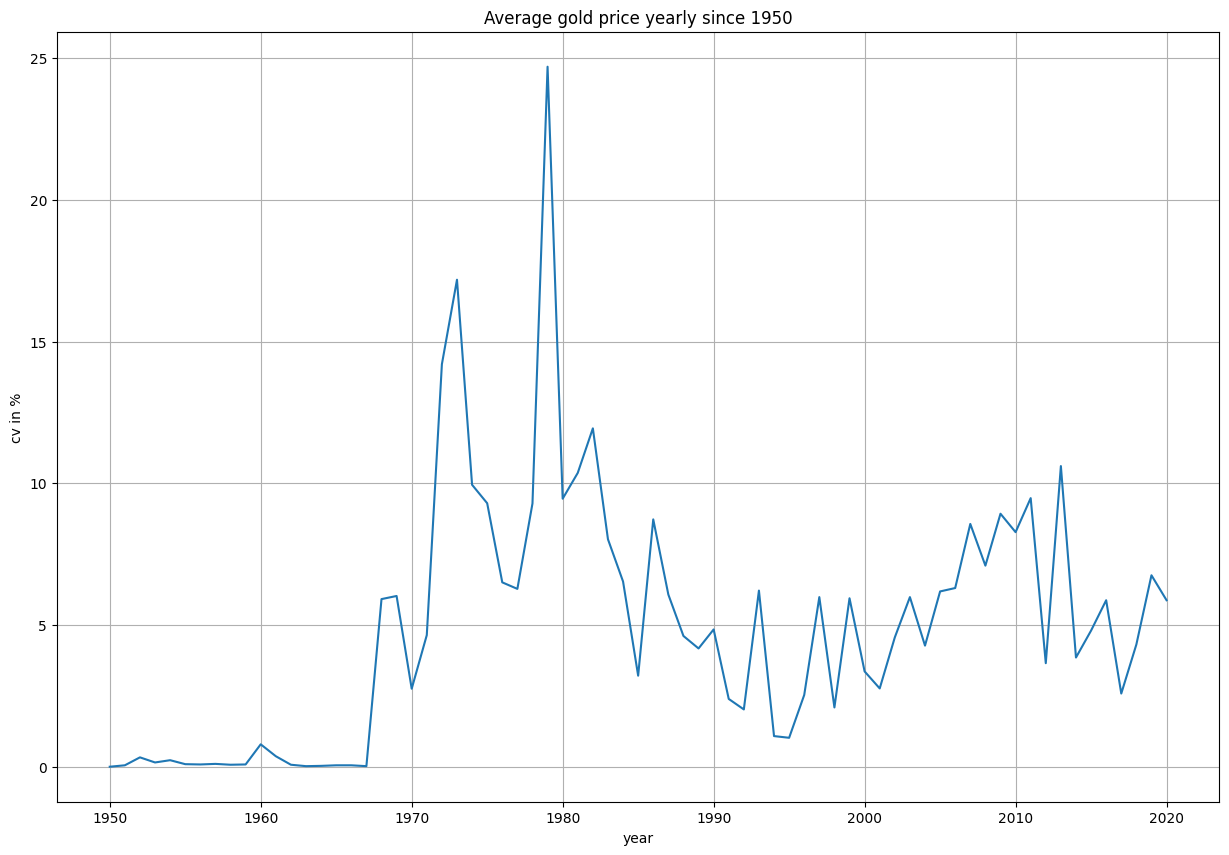

In [18]:
fig, ax = plt.subplots(figsize = (15,10))
df_1['Cov_pct'].plot()
plt.title('Average gold price yearly since 1950')
plt.xlabel('year')
plt.ylabel('cv in %')
plt.grid()

In [19]:
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]

In [20]:
train.shape, test.shape

((792, 1), (55, 1))

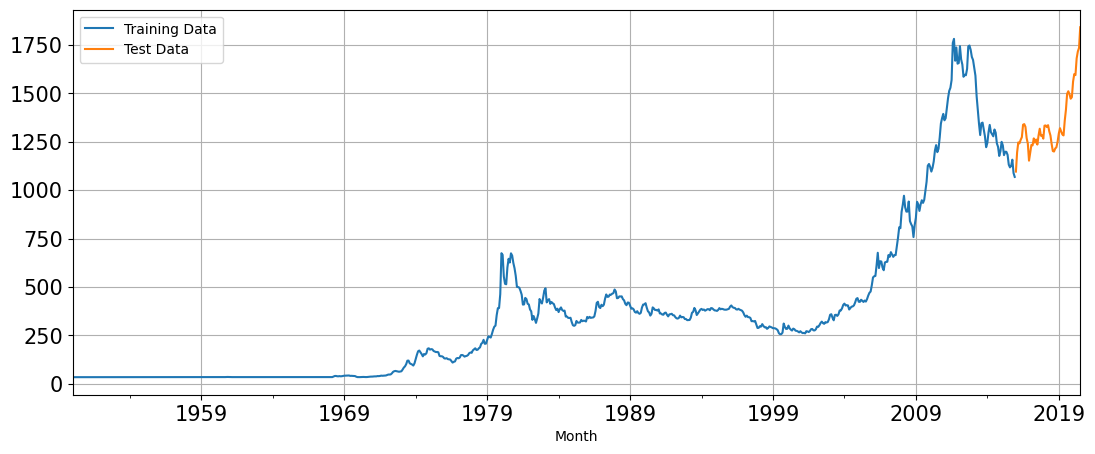

In [21]:
train['Price'].plot(figsize = (13,5), fontsize = 15)
test['Price'].plot(figsize = (13,5), fontsize = 15)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

In [22]:
train_time = [i+1 for i in range(len(train))]
test_time = [i + len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

In [23]:
LR_train = train.copy()
LR_test = test.copy()

In [24]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [27]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train['Price'].values)

LinearRegression()

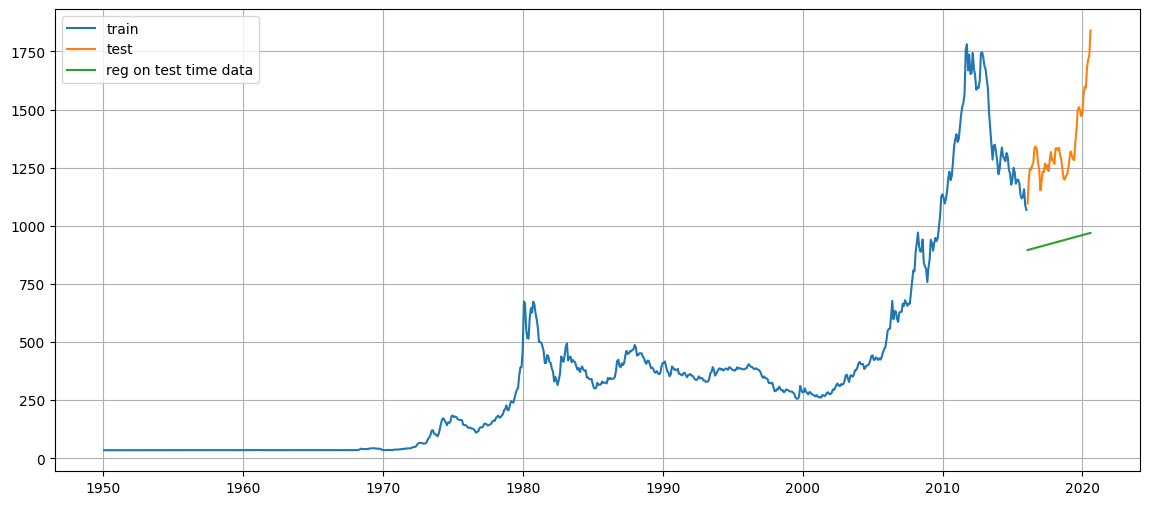

In [30]:
test_prediction_model1 = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_prediction_model1

plt.figure(figsize = (14,6))
plt.plot(train['Price'], label = 'train')
plt.plot(test['Price'], label = 'test')
plt.plot(LR_test['forecast'], label = 'reg on test time data')
plt.legend(loc = 'best')
plt.grid()

In [31]:
def mape(actual,pred):
  return round(np.mean(abs(actual- pred)/actual)*100,2)

In [32]:
mape_model1_test = mape(test['Price'].values,test_prediction_model1)
print('MAPE is %3.3f'%(mape_model1_test),'%')

MAPE is 29.760 %


In [34]:
results = pd.DataFrame({'Test MAPE (%)':[mape_model1_test]}, index = ['RegressionOnTime'])
results

,Test MAPE (%)
RegressionOnTime,29.76


In [35]:
Naive_train = train.copy()
Naive_test = test.copy()

In [36]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

Month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

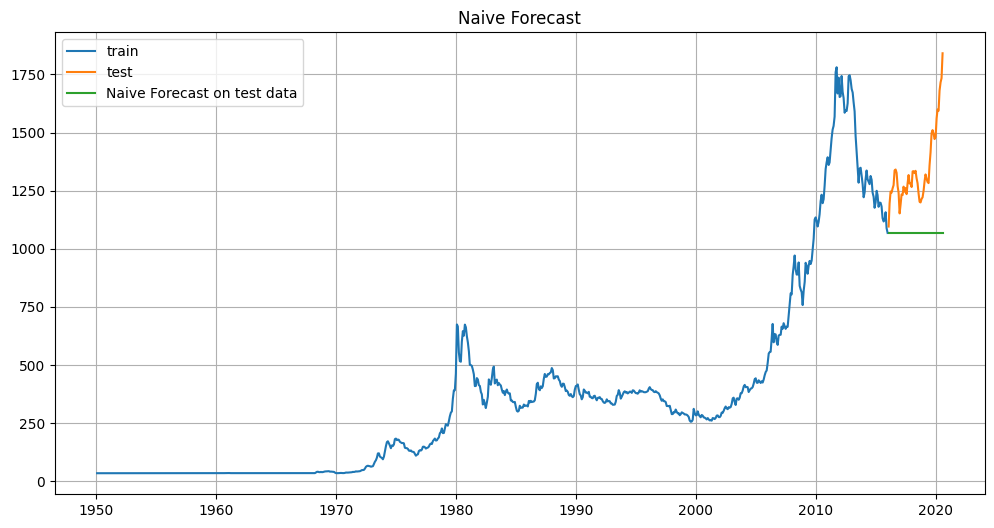

In [38]:
plt.figure(figsize = (12,6))
plt.plot(Naive_train['Price'], label = 'train')
plt.plot(test['Price'], label = 'test')
plt.plot(Naive_test['naive'], label = 'Naive Forecast on test data')
plt.legend(loc = 'best')
plt.title('Naive Forecast')
plt.grid()

In [40]:
mape_model2_test = mape(test['Price'].values,Naive_test['naive'].values)
print('For Naive forecast MAPE is %3.3f'%(mape_model2_test),'%')

For Naive forecast MAPE is 19.380 %


In [41]:
resultsDf_2 = pd.DataFrame({'Test MAPE (%)':[mape_model2_test]}, index = ['NaiveModel'])
results = pd.concat([results,resultsDf_2])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38


In [42]:
final_model = ExponentialSmoothing(df, trend = 'additive',seasonal='additive').fit(
    smoothing_level = 0.4,
    smoothing_trend = 0.3,
    smoothing_seasonal = 0.6
)

In [43]:
Mape_final_model = mape(df['Price'].values,final_model.fittedvalues)
print("MAPE:",Mape_final_model)

MAPE: 17.24


In [45]:
predictions = final_model.forecast(steps=len(test))

In [47]:
pred_df = pd.DataFrame({'lower_CI': predictions - 1.96*np.std(final_model.resid,ddof=1),
                        'prediction': predictions,
                        'upper_CI': predictions + 1.96*np.std(final_model.resid,ddof=1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-31,1684.720065,1792.871037,1901.022009
2020-09-30,1615.306077,1723.457050,1831.608022
2020-10-31,1538.567922,1646.718895,1754.869867
2020-11-30,1476.758600,1584.909572,1693.060545
2020-12-31,1459.327290,1567.478262,1675.629235


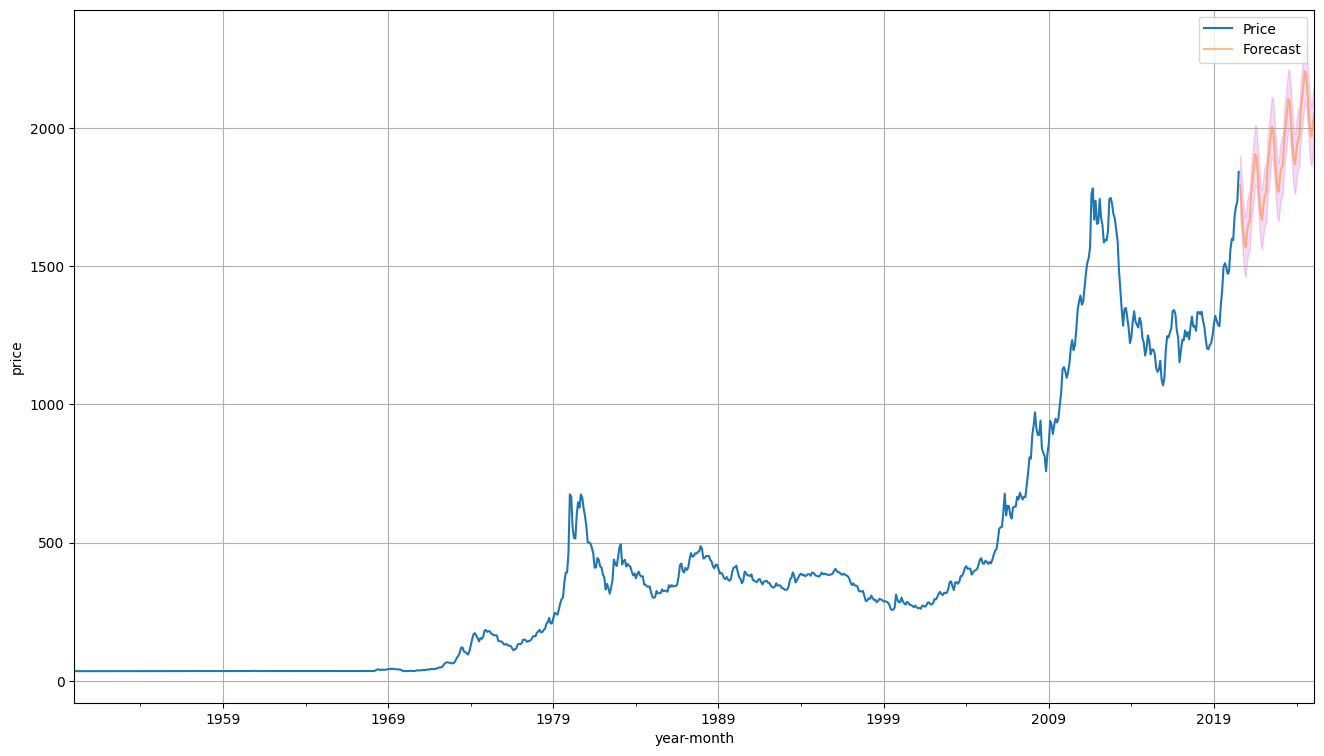

In [51]:
axis = df.plot(label = 'Actual', figsize = (16,9))
pred_df['prediction'].plot(ax = axis, label = 'Forecast', alpha = 0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color = 'm', alpha = 0.15)
axis.set_xlabel('year-month')
axis.set_ylabel('price')
plt.legend(loc = 'best')
plt.grid()
plt.show()